Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read Data from CSV

In [2]:
import os
import cv2
import torch
import pickle
import albumentations
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# finalDataPath = "img_data.csv"
finalDataPath = "gdrive/My Drive/model/img_data.csv"

data = pd.read_csv(finalDataPath)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
data.head()

,image,text
0,TRSynth100K/images/00000000.jpg,life
1,TRSynth100K/images/00000001.jpg,not
2,TRSynth100K/images/00000002.jpg,while
3,TRSynth100K/images/00000003.jpg,know
4,TRSynth100K/images/00000004.jpg,clearly


Modify Pathnames for Use on Google Drive

In [4]:
for i in range(len(data["image"])):
    data["image"][i] = "gdrive/My Drive/model/" + data["image"][i]

Create Text Mapping Alphabet

In [5]:
alphabet = list({c for word in data['text'] for c in str(word)})
alphabet.sort()

In [6]:
alphabet

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:
charToInt = {a: i for i, a in enumerate(alphabet)}
intToChar = {i: a for i, a in enumerate(alphabet)}
print(charToInt)
print(len(alphabet))

{'#': 0, '$': 1, '%': 2, '&': 3, "'": 4, '(': 5, ')': 6, '*': 7, '+': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '<': 25, '=': 26, '>': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80}
81


In [8]:
def save_obj(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(charToInt, "charToInt.pkl")
save_obj(intToChar, "intToChar.pkl")

Split Data Into Train and Validation Data

In [9]:
train, valid = train_test_split(data, test_size=0.2)

Load and Normalize Image Data

In [11]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

trainImg = []
trainImgLen = []
trainText = []
trainTextLen = []
validImg = []
validImgLen = []
validText = []
validTextLen = []

maxLen = data["text"].apply(lambda x: len(str(x))).max()
aug = albumentations.Compose([albumentations.Normalize(max_pixel_value = 255, always_apply = True)])

for i in range(int(len(train))):
    img = cv2.imread(train["image"][i])
    if type(img) == type(None):
        continue
    img = aug(image = img)["image"]
    trainImg.append(img)
    trainText.append([charToInt[j] for j in str(train['text'][i])])
    trainText[i] = trainText[i] + [len(alphabet)] * (maxLen - len(trainText[i]))
    trainImgLen.append(39)
    trainTextLen.append(maxLen)

for i in range(int(len(valid))):
    img = cv2.imread(valid["image"][i])
    if type(img) == type(None):
        continue
    img = aug(image = img)["image"]
    validImg.append(img)
    validText.append([charToInt[j] for j in str(valid['text'][i])])
    validText[i] = validText[i] + [len(alphabet)] * (maxLen - len(validText[i]))
    validImgLen.append(39)
    validTextLen.append(maxLen)

trainImg = np.array(trainImg)
trainText = np.array(trainText)
trainImgLen = np.array(trainImgLen)
trainTextLen = np.array(trainTextLen)
validImg = np.array(validImg)
validText = np.array(validText)
validImgLen = np.array(validImgLen)
validTextLen = np.array(validTextLen)


[73 55 79 73 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81]
24000
6000
[[73 55 79 ... 81 81 81]
 [60 69 72 ... 81 81 81]
 [59 76 59 ... 81 81 81]
 ...
 [73 63 58 ... 81 81 81]
 [75 68 76 ... 81 81 81]
 [35 66 55 ... 81 81 81]]


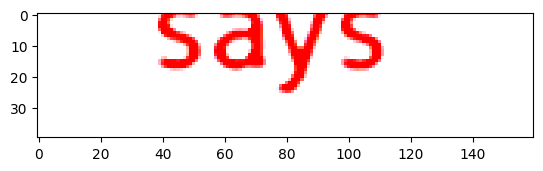

In [12]:
plt.imshow(trainImg[0])
print(trainText[0])
print(len(trainImg))
print(len(validText))
print(trainText)

Build Model

In [13]:
inputLayer = tf.keras.layers.Input(shape = (40, 160, 3))
labelLayer = tf.keras.layers.Input(shape = [maxLen])
inputLen = tf.keras.layers.Input(shape = [1])
labelLen = tf.keras.layers.Input(shape = [1])

In [14]:
rcnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),

    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2),

    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 1)),

    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.MaxPool2D(pool_size = (2, 1)),

    tf.keras.layers.Conv2D(filters = 512, kernel_size = (2, 2), activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Reshape((-1, 512)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.2))
])
rcnn(inputLayer)
output = tf.keras.layers.Dense(len(alphabet) + 1, activation = "softmax")(rcnn.output)
testModel = tf.keras.models.Model(inputs = inputLayer, outputs = output)

In [15]:
rcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 160, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 160, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 160, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 80, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 80, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 20, 80, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 40, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 40, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 10, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 40, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 40, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 40, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 5, 40, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 40, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 40, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 5, 40, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 40, 512)          │              

 Total params: 4,247,680 (16.20 MB)

 Trainable params: 4,244,224 (16.19 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [16]:
testModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 160, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 39, 256)             │       4,247,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39, 82)              │          21,074 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,268,754 (16.28 MB)

 Trainable params: 4,265,298 (16.27 MB)

 Non-trainable params: 3,456 (13.50 KB)

Define CTC Loss Function

In [17]:
lossOut = tf.keras.layers.Lambda(lambda x: tf.keras.backend.ctc_batch_cost(x[0], x[1], x[2], x[3]), output_shape=(1,), name = 'ctc')([labelLayer, output, inputLen, labelLen])

Train the Model

In [18]:
# trainText = tf.keras.Input(shape=trainText.shape, dtype=trainText.dtype)
# trainImgLen = tf.keras.Input(shape=trainImgLen.shape, dtype=trainImgLen.dtype)
# trainTextLen = tf.keras.Input(shape=trainTextLen.shape, dtype=trainTextLen.dtype)

trainingData = [trainImg, trainText, trainImgLen, trainTextLen]
validationData = [validImg, validText, validImgLen, validTextLen]

trainingModel = tf.keras.models.Model(inputs = [inputLayer, labelLayer, inputLen, labelLen], outputs = lossOut)
trainingModel.compile(loss = {'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
trainingModel.fit(x = trainingData, y = np.zeros(len(trainImg)), batch_size = 256, epochs = 5)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3220s 34s/step - loss: 35.2569
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3250s 34s/step - loss: 17.6180
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3181s 34s/step - loss: 16.8078
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3175s 34s/step - loss: 14.0378
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3159s 33s/step - loss: 4.9748


In [ ]:
trainResult = trainingModel.predict([np.array([testImg]), np.array([testLabel]), np.array([39]), np.array([maxLen])])
trainResult = np.expand_dims(trainResult, axis=2)
trainResult = np.repeat(trainResult, len(alphabet), axis=2)
monday = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(trainResult, input_length = np.ones(trainResult.shape[0]) * trainResult.shape[1],
                                                                greedy = True)[0][0])
print(monday)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[0]]


In [19]:
trainingModel.save_weights("gdrive/My Drive/model/rcnn.weights.h5")

Testing Model Results

In [20]:
testModel.load_weights("gdrive/My Drive/model/rcnn.weights.h5")

[49, 70, 58, 55, 74, 59, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]


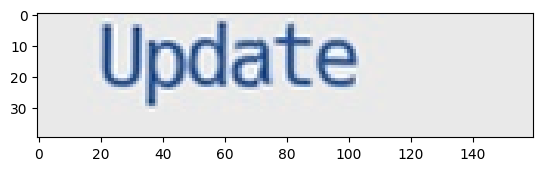

In [21]:
# testImg = cv2.imread("gdrive/My Drive/model/TRSynth100K/images/00000018.jpg")
tLabel = "Update"
testLabel = [charToInt[j] for j in tLabel] + [len(alphabet)] * (maxLen - len(tLabel))
testImg = cv2.imread("gdrive/My Drive/model/TRSynth100K_small/images/00000018.jpg")
plt.imshow(testImg)
print(testLabel)

In [22]:
testImg = aug(image = testImg)["image"]
testResult = testModel.predict(np.array([testImg]))
result = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(testResult, input_length = np.array([maxLen]),
                                                                beam_width = 100)[0][0])
testModel.summary()
print(result)
# print(testModel.layers[1].get_weights())
# print(maxLen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 160, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 39, 256)             │       4,247,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39, 82)              │          21,074 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,268,754 (16.28 MB)

 Trainable params: 4,265,298 (16.27 MB)

 Non-trainable params: 3,456 (13.50 KB)

[[61 63 55 74 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [ ]:
trainingModel.summary()
print(testModel.layers[1].get_weights())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40, 160, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 39, 256)        │      4,247,680 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 39, 46)         │         11,822 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc (Lambda)              │ (None, 1)              │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ dense[0][0],           │
│                           │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,771,596 (48.72 MB)

 Trainable params: 4,256,046 (16.24 MB)

 Non-trainable params: 3,456 (13.50 KB)

 Optimizer params: 8,512,094 (32.47 MB)

[array([[[[-0.08474103,  0.00410535, -0.07665706, ..., -0.07903594,
           0.09948377,  0.09860162],
         [-0.03247814,  0.05182328,  0.08635817, ...,  0.00601674,
          -0.01278572, -0.06139739],
         [-0.00813988, -0.01399527,  0.06910028, ..., -0.01397698,
           0.03043523,  0.08941839]],

        [[ 0.0685712 ,  0.01193727, -0.00480787, ...,  0.03117501,
          -0.02524077,  0.06090505],
         [ 0.05829557,  0.0691379 , -0.01083142, ...,  0.02895145,
           0.07315123,  0.00772998],
         [-0.086744  , -0.0577763 , -0.0247943 , ..., -0.0273658 ,
          -0.00206268, -0.07681205]],

        [[-0.06191224,  0.0219846 , -0.04781481, ...,  0.06248514,
          -0.03990447, -0.0729897 ],
         [-0.04563031,  0.06807402,  0.03815739, ..., -0.07191529,
           0.03173877, -0.04347987],
         [ 0.05505773, -0.05307562,  0.02099907, ...,  0.07949684,
           0.03213676, -0.04381934]]],


       [[[ 0.04255961,  0.0101609 ,  0.07960306, ...,  